In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import math
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point
import pyreadr
import mercantile
from shapely.geometry import shape
import networkx as nx
import scipy
import scipy.sparse as sp
import pickle
from functools import partial
import seaborn as sns
#from pygenstability import run, plotting
from sklearn import metrics

In [3]:
pip install pygenstability

Note: you may need to restart the kernel to use updated packages.


# Aggregation of baseline data to baseline daily DiGraph

## Aggregation of data

Generate baseline daily DiGraph by summing up daily trips and averaging over the baseline week.

In [4]:
###############
# Import data #
###############

root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data'

#Reads in the baseline between tiles movment
root1 = root_data+'/BETWEEN_TILES_BASELINE.csv'
df = pd.read_csv(root1)

#Converting the quadkeys to strings
df['start_quadkey'] = df['start_quadkey'].astype(str)
df['end_quadkey'] = df['end_quadkey'].astype(str)
#adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']

# Replace nan with 0
df = df.fillna(0)

#################################
# Filtering out rows outside UK #
#################################

# Load filtered quadkeys
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results'
root2 = root_results+'/Filtering'+'/base_quadkeys_filtered.pickle'
root_base = root_results+'/Base Network/'
with open(root2, 'rb') as handle:
    quadkeys_baseline_UK = pickle.load(handle)
    
quadkeys_baseline_UK = set(quadkeys_baseline_UK)

df_filtered = df.copy()

for i in range(df.shape[0]):

    start_included =  df.iloc[i]['start_quadkey'] in quadkeys_baseline_UK 
    end_included = df.iloc[i]['end_quadkey'] in quadkeys_baseline_UK 
    included = start_included + end_included

    if included != 2:
        df_filtered = df_filtered.drop([i])
        
print('Number of deleted rows:', df.shape[0] - df_filtered.shape[0])

df = df_filtered.reset_index(drop=True)

#store dataframe

df.to_csv(root_results+'/Base Network/BaseFilteredDataFrame.csv',index=False) 

##################
# Aggregate data #
##################

df_key = df.iloc[:,:2]

# Get daily movements by summation
M = df.shape[1]-3
days = []

for i in range(1,M,3):

    df_mov = df.iloc[:,i+1:i+4]
    df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
    days.append(df_sum)

# Compute weekly average
all_days = days[0]

for i in range(1,len(days)):
    all_days += days[i]
    
all_days = all_days/len(days)
df_mean = pd.concat([df_key,all_days],axis=1)

####################
# Generate DiGraph #
####################

N = len(df_mean)
G = nx.DiGraph()

# for each row, add nodes and weighted edge
for i in range(0,N):
    start = df_mean['start_quadkey'][i]
    end = df_mean['end_quadkey'][i]
    weight = df_mean['movement'][i]
    G.add_node(start)
    G.add_node(end)
    if weight > 0.0:
        G.add_weighted_edges_from([(start, end, weight)] )
        
###############
# Store Graph #
###############

root_Base = '/Users/ignaciosacristanbarba/Documents/M4R/Results'+'/Base Network/'
root_G_dict = root_base+'/base_network.npz'

G_dict = nx.to_dict_of_dicts(G)
# Store data (serialize)
with open(root_G_dict, 'wb') as handle:
    pickle.dump(G_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Number of deleted rows: 4320


In [5]:
####################################
# Compute geometric node positions #
####################################

# Get polygons from quadkeys
quadkeys = list(G.nodes)
n_nodes = len(quadkeys)
polys = []

#Iterates over the quadkeys to extract the tiles
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]

#  add polygon centroids as node attributes 
geom_dict = {quadkeys[i] : list(geom[i].centroid.bounds[:2]) for i in range(0,n_nodes)}
nx.set_node_attributes(G,geom_dict,'geom')

# Save geom_dict to file
with open(root_base+'base_geom_dict.pickle', 'wb') as handle:
    pickle.dump(geom_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Store node numbers
node_numbers = {i : list(G.nodes())[i] for i in range(n_nodes)}
node_dict = {list(G.nodes)[i] : i for i in range(n_nodes)}

# Gemo dict for node keys
geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}

# Store node attributes in data frame
node_attributes = pd.DataFrame({'key' : quadkeys, 'geom' : geom_dict.values()})

###################################
# Compute distances between tiles #
###################################

gdf = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")

def getXY(pt):
    return (pt.x, pt.y)
centroidseries = gdf['geometry'].centroid
gdf['LONGITUDE'],gdf['LATITUDE'] = [list(t) for t in zip(*map(getXY, centroidseries))]

from math import radians, cos, sin, asin, sqrt

pt_lat = dict(zip(gdf['quadkey'], gdf['LATITUDE']))
pt_long = dict(zip(gdf['quadkey'], gdf['LONGITUDE']))

pt_lat_r = {k: math.radians(v) for k, v in pt_lat.items()}
pt_long_r = {k: math.radians(v) for k, v in pt_long.items()}

pt_tup_1 = []
pt_tup_2 = []
dist_tup = []

# Compute distance in km with Haversine formula
for i in pt_lat_r.keys():
    for j in pt_lat_r.keys():
        pt_tup_1.append(i)
        pt_tup_2.append(j)        
        dist_tup.append(6367 * (2 * asin(sqrt(sin((pt_lat_r.get(i) - pt_lat_r.get(j))/2)**2 + cos((pt_lat_r.get(i))) * cos((pt_lat_r.get(j))) * sin((pt_long_r.get(i) - pt_long_r.get(j))/2)**2))))
        
#Creates Dataframe from tuple
Dist = pd.DataFrame({'start_quadkey': pt_tup_1,'end_quadkey': pt_tup_2,'DISTANCE': dist_tup})

# Compute distance matrix D_geom
D_geom = np.zeros((n_nodes,n_nodes))
for i in range(n_nodes):
    D_geom[i,:] = Dist['DISTANCE'][i*n_nodes:(i+1)*n_nodes]
    
# Store D_geom
root_D_geom = root_base + '/base_D_geom.pickle'
with open(root_D_geom, 'wb') as handle:
    pickle.dump(D_geom, handle, protocol=pickle.HIGHEST_PROTOCOL)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [6]:
root_figure = '/Users/ignaciosacristanbarba/Documents/M4R/Figures/'

https://en.wikipedia.org/wiki/Haversine_formula

## Visualisation of baseline daily DiGraph



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


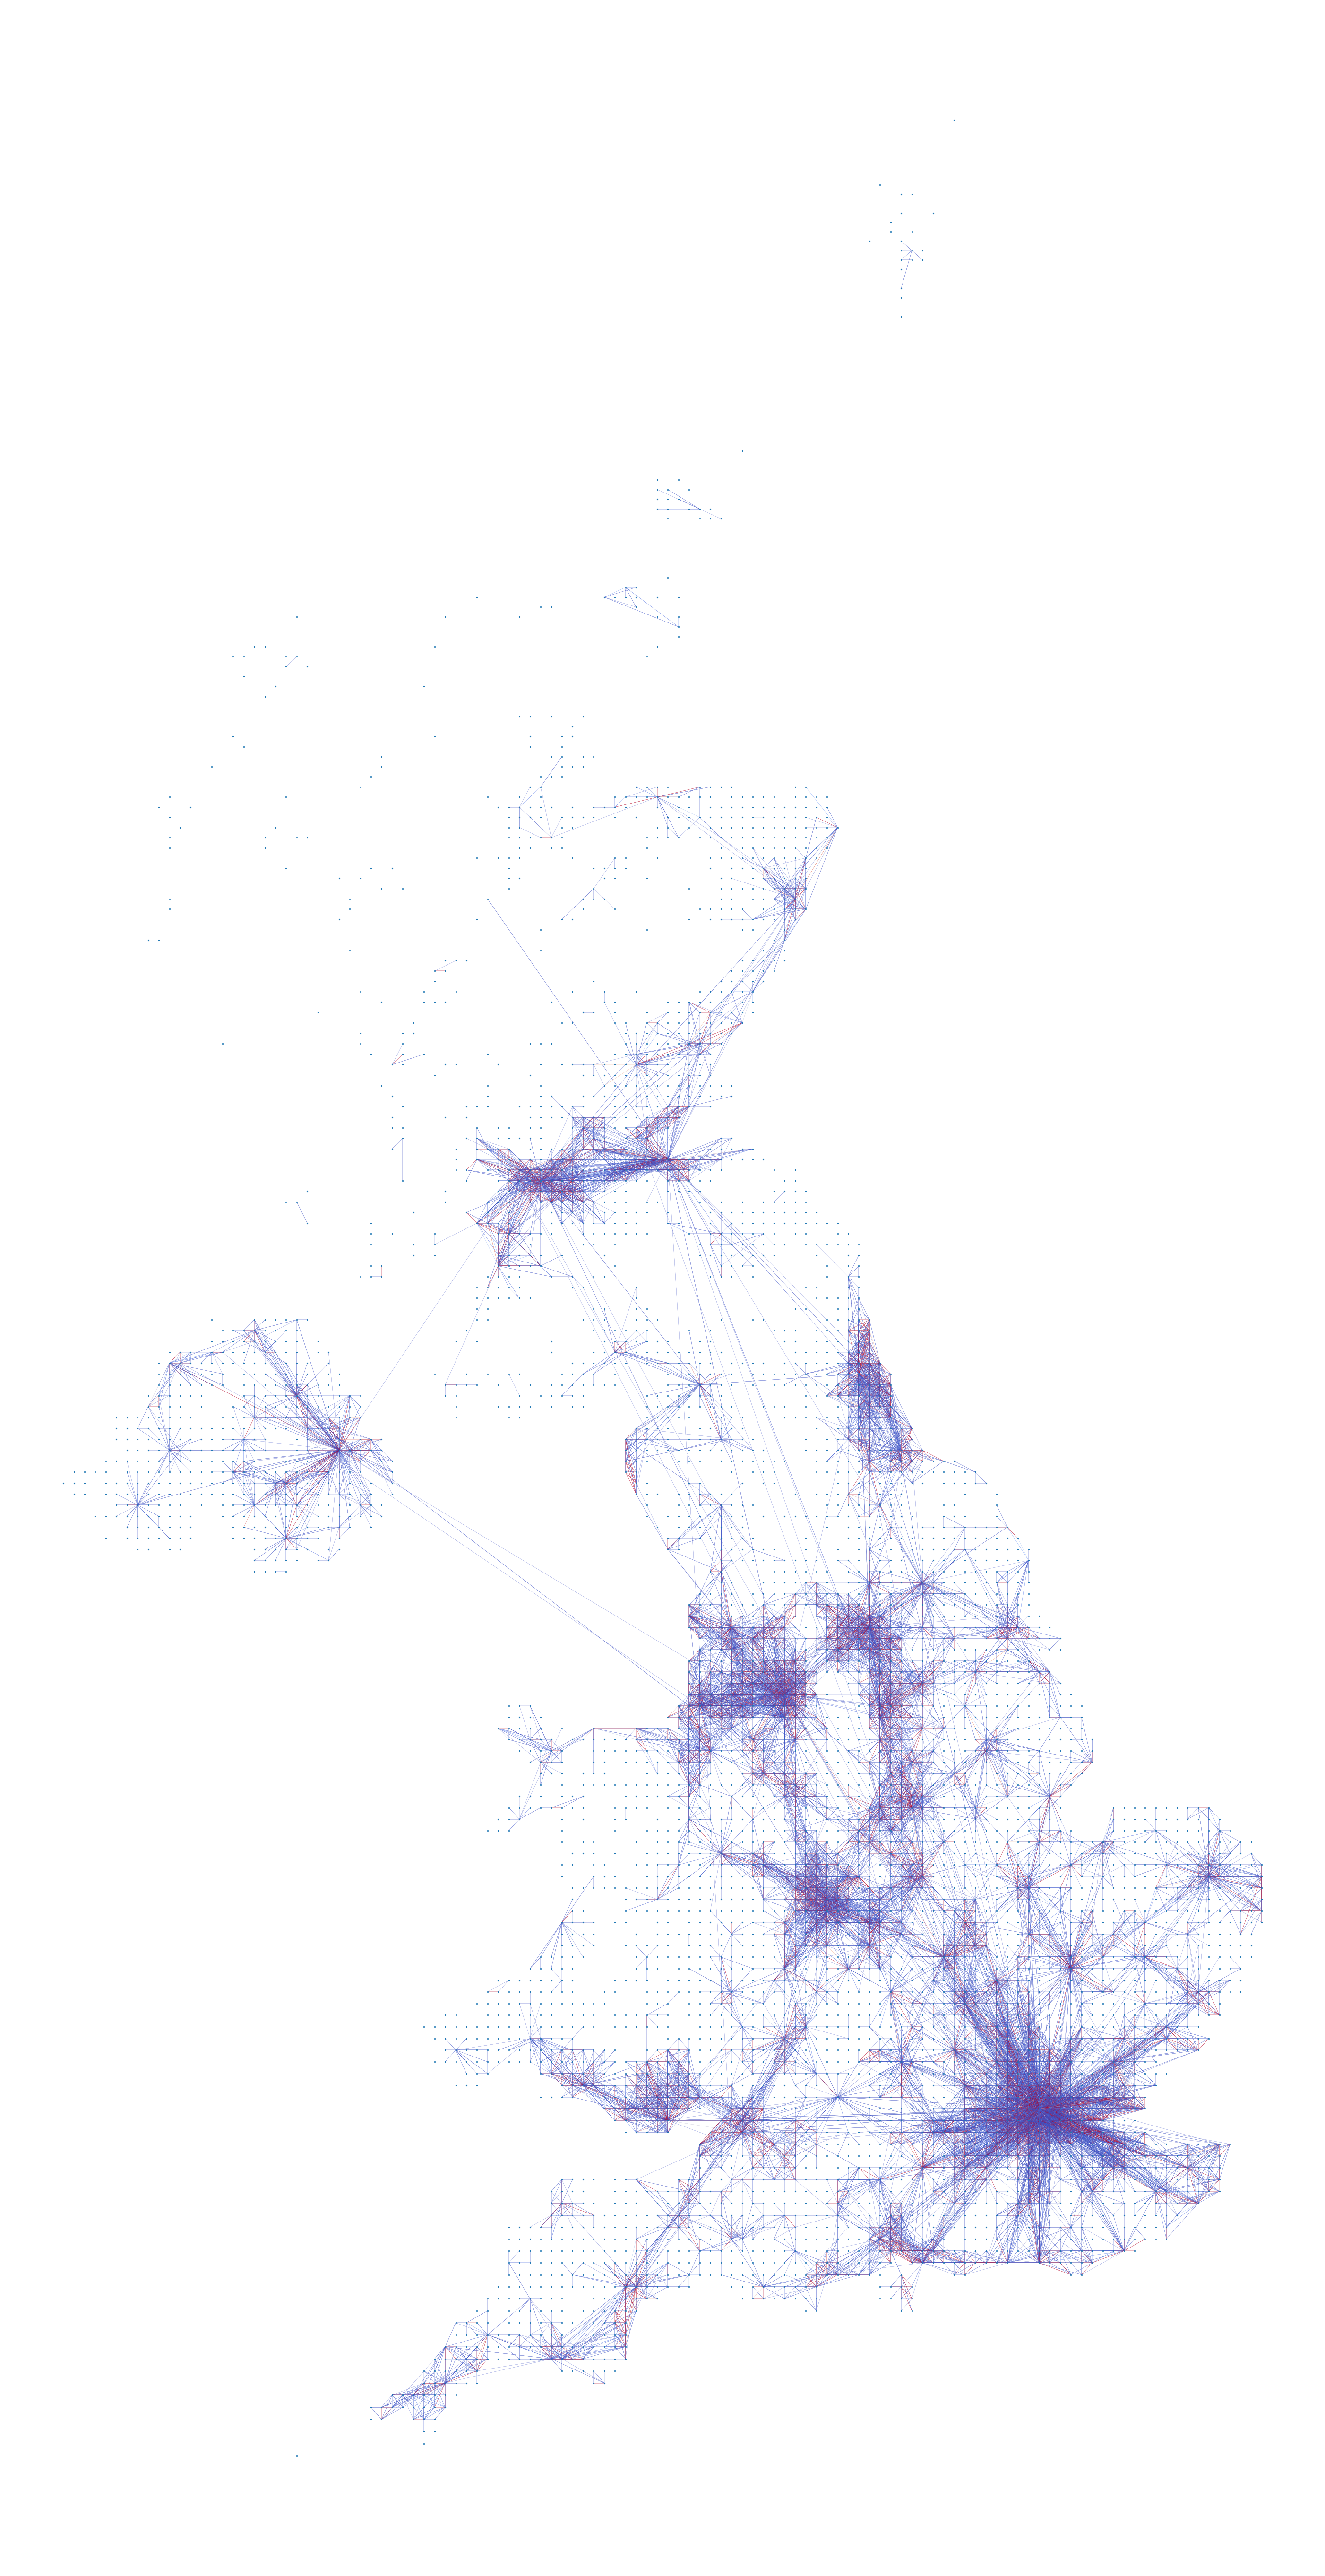

In [7]:

import matplotlib.colors as mcolors

weights = np.asarray(list(nx.get_edge_attributes(G,'weight').values()))
colors = np.exp(weights/9)
colors = plt.cm.coolwarm(np.asarray(colors,dtype='int'))

# Create subplot and draw graph
fig, ax = plt.subplots(1,figsize =(50,100))
nx.draw(G, ax=ax, pos=geom_dict, node_size=5, width = 0.3,  arrows=False,
       edge_color = colors)
#ax.set(title='Baseline Daily DiGraph')
plt.show()

In [8]:
#read the geo-dataframe with the shapes of the NUTS3
root4 = root_results + '/NUTS3_graph' + '/gdf_NUTS3.shp'
gdf_NUTS3 = gpd.read_file(root4)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


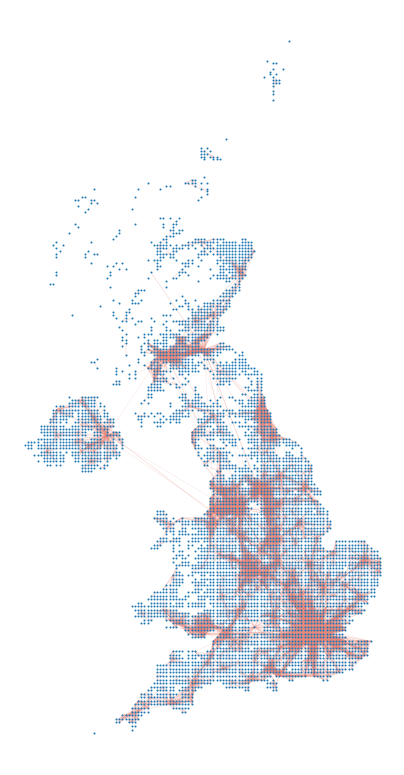

In [9]:
import matplotlib.colors as mcolors

weights = np.asarray(list(nx.get_edge_attributes(G,'weight').values()))
colors = np.exp(weights/9)
colors = plt.cm.coolwarm(np.asarray(colors,dtype='int'))

# Create subplot and draw graph
fig, ax = plt.subplots(1,figsize =(7,14))
# nx.draw(G, ax=ax, pos=geom_dict, node_size=5, width = 0.3,  arrows=False,
#        edge_color = colors)

#gdf_NUTS3.boundary.plot(linewidth=0.5, ax=ax, color = 'black',alpha = 0.1)
nx.draw(G,node_size = 1,width=0.1,ax = ax,pos =geom_dict ,arrows = False,edge_color='#E9887B')
#ax.set(title='Baseline Daily DiGraph')
plt.show()
fig.savefig(root_figure+'/full_graph.pdf')

## Descriptive statistics for baseline daily DiGraph

### Basic characteristics

In [10]:
# Compute basic characteristics
print('Number of nodes:', n_nodes)
print('Number of edges:', len(weights))
print('Total number of moving people:', np.around(np.sum(nx.adjacency_matrix(G).toarray()),2))
print('Mean link weight:', np.around(weights.mean(),2))
print('Coefficient of variation of link weight:', np.around(weights.std()/weights.mean(),2))

# Compute statistical symmetry
from sklearn.metrics import r2_score
A = nx.adjacency_matrix(G).toarray()
y_true = A.flatten()
y_pred = np.transpose(A).flatten()
print('R2 of statistical symmetry:', r2_score(y_true,y_pred))

# Compute number of WCCs and size of LWCC
n_wcc = nx.algorithms.components.number_weakly_connected_components(G)
G_lwcc = max(nx.algorithms.components.weakly_connected_components(G), key=len)
s_lwcc = len(G_lwcc)

print('Number of WCCs:', n_wcc)
print('Size of LWCC:', s_lwcc)



# Compute number of SCCs and size of LSCC
n_scc = nx.algorithms.components.number_strongly_connected_components(G)
s_lscc = len(max(nx.algorithms.components.strongly_connected_components(G), key=len))
print('Number of SCCs:', n_scc)
print('Size of LSCC:', s_lscc)

Number of nodes: 5436
Number of edges: 40238
Total number of moving people: 13234564.06
Mean link weight: 328.91
Coefficient of variation of link weight: 5.73
R2 of statistical symmetry: 0.999978630842305
Number of WCCs: 1956
Size of LWCC: 3405
Number of SCCs: 2193
Size of LSCC: 3125


In [11]:
#compute number of trips
n_total = A.sum()
n_intra = np.trace(A)
n_inter = n_total-n_intra

print('Total number of trips in Full G:',n_total)
print('Intra-tile number of trips in Full G:',n_intra)
print('Inter-tile number of trips in Full G:',n_inter)



Total number of trips in Full G: 13234564.064285686
Intra-tile number of trips in Full G: 10749639.642857144
Inter-tile number of trips in Full G: 2484924.4214285426


### Self-loop weight distribution and degree distribution

Number of nodes without self-loops:  1
Number of nodes with low-weight (<10) self-loops:  156


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


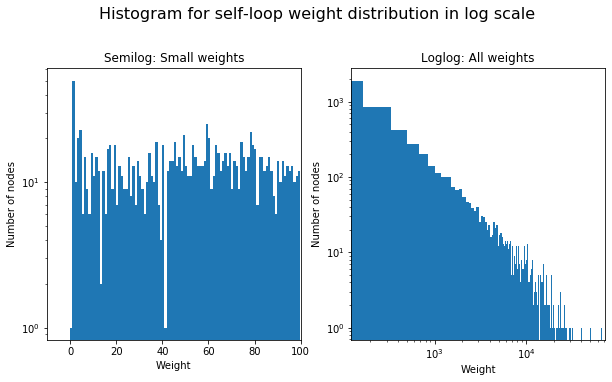

In [12]:
#number of self-loops
self_loops = np.diag(A)

print('Number of nodes without self-loops: ', sum(self_loops == 0))
print('Number of nodes with low-weight (<10) self-loops: ', sum(self_loops < 10))

self_loops_low = self_loops[self_loops<100]

# Plot histogram for self-loop weight distribution in log scale
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(wspace=0.2)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(self_loops_low,100)
ax1.set(ylabel = 'Number of nodes' ,title = 'Semilog: Small weights', 
       xlabel='Weight', xlim = (-10, 100),  yscale='log')
ax2.hist(self_loops,430)
ax2.set(ylabel = 'Number of nodes' ,title = 'Loglog: All weights', 
       xlabel='Weight', xlim = (0, np.max(self_loops)),  yscale='log', xscale = 'log')

fig.suptitle('Histogram for self-loop weight distribution in log scale', fontsize=16, y =1.05)

plt.show()

Remark: Weight 0 means that there is no edge, by construction of the DiGraph.

Minimal degree: 1
Mean degree: 14.804267844002943


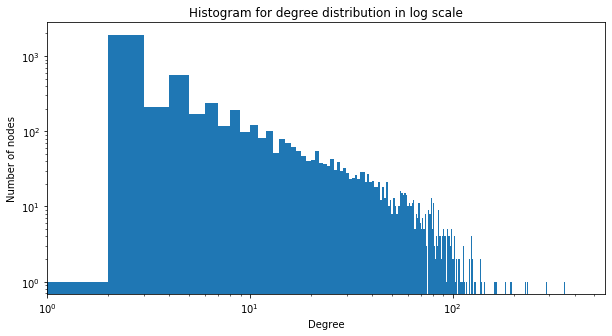

In [13]:
# Compute degrees
degrees = np.asarray(list(dict(G.degree()).values()))
max_degree = np.max(degrees)
print('Minimal degree:', np.min(degrees))
print('Mean degree:',np.mean(degrees))
# Plot histogram for degree distribution in log scale
fig, ax = plt.subplots(1,figsize =(10,5))
ax.hist(degrees,bins=max_degree)
ax.set(ylabel = 'Number of nodes' ,title = 'Histogram for degree distribution in log scale', 
       xlabel='Degree', xlim=(1,max_degree+5),yscale='log',xscale='log')

plt.show()

This means that there are no nodes without any loops, which was expected as those tiles are not in the dataset. In particular, the nodes without self-loops are still connected to different tiles. 

Mean in-degree: 7.402133922001472
Mean out-degree: 7.402133922001472
Max in-degree: 266
Max out-degree: 294


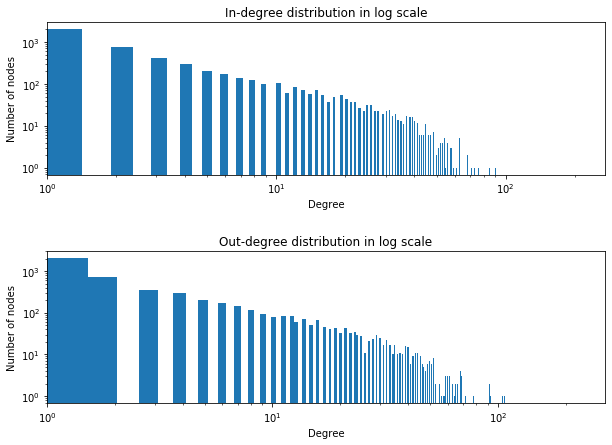

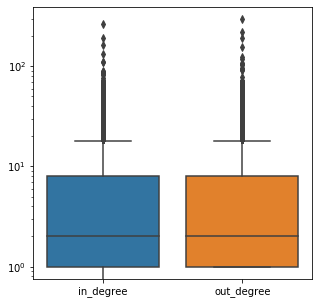

In [14]:
# Compute in-degrees
in_degrees = np.asarray(list(dict(G.in_degree()).values()))
max_in_degree = np.max(in_degrees)

# Compute out-degrees
out_degrees = np.asarray(list(dict(G.out_degree()).values()))
max_out_degree = np.max(out_degrees)

# Compute means and max
print('Mean in-degree:', in_degrees.mean())
print('Mean out-degree:', out_degrees.mean())
print('Max in-degree:', in_degrees.max())
print('Max out-degree:', out_degrees.max())

# Store results
node_attributes['in_degree'] = in_degrees
node_attributes['out_degree'] = out_degrees

# Plot histogram for in- and out-degree distribution in log scale
fig = plt.figure(figsize=(10,7))
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.hist(in_degrees,bins=max_degree)
ax1.set(ylabel = 'Number of nodes' ,title = 'In-degree distribution in log scale', 
       xlabel='Degree', xlim=(1,max_in_degree+5),yscale='log',xscale='log')
ax2.hist(out_degrees,bins=max_degree)
ax2.set(ylabel = 'Number of nodes' ,title = 'Out-degree distribution in log scale', 
       xlabel='Degree', xlim=(1,max_out_degree+5),yscale='log',xscale='log')
plt.show()

# Plot boxplots for degree distribution in log scale
fig, ax = plt.subplots(1,figsize =(5,5))
sns.boxplot(data = node_attributes.iloc[:,2:], ax =ax)
ax.set(yscale = 'log')
plt.show()

In [15]:
np.mean(degrees)

14.804267844002943

# LWCC



## Exploration and descriptive statistics of LWCC

In [16]:
new_computation = False

if new_computation == False:
    
    # Load data (deserialize)
    with open(root_Base+'/base_network_lwcc.npz', 'rb') as handle:
        lwcc_dict = pickle.load(handle)
    # Create DiGraph
    lwcc = nx.from_dict_of_dicts(lwcc_dict,create_using = nx.DiGraph)
    
elif new_computation == True:

    # Create subgraph of LWCC and save adjacency matrix
    lwcc_nodes = max(nx.weakly_connected_components(G), key=len)
    lwcc = G.subgraph(lwcc_nodes)
    lwcc_dict = nx.to_dict_of_dicts(lwcc)
    # Store data (serialize)
    with open(root_base+'/base_network_lwcc.npz', 'wb') as handle:
        pickle.dump(lwcc_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# Compute adjacency matrix and node list of LWCC
A = nx.adjacency_matrix(lwcc)
lwcc_nodes_list = np.asarray(list(lwcc.nodes()))
s_lwcc = len(lwcc_nodes_list)
print('Muber of nodes of LWCC:', s_lwcc)
print('Number of edges of LWCC:', len(lwcc.edges()))

# Compute sparsity of adjacency matrix
sparsity = 100*np.sum(A.toarray() == 0.) / A.toarray().size
print('Sparsity of LWCC:', np.around(sparsity,2),'%')

# Associate quadkeys and node ids with key.
lwcc_node_dict = {list(lwcc.nodes)[i] : i for i in range(s_lwcc)}

# Subtract self-loops
B_array = A - np.diag(np.diag(A.toarray()))
B = sp.csr_matrix(B_array)
# Compute vector of out-strengths
ones = np.ones(s_lwcc)
d = np.asarray(B_array.dot(ones)[0]).reshape(-1)
print('Number of sink nodes:', np.sum(d==0))
print('Number of edges in B:', np.sum(B_array > 0))

Muber of nodes of LWCC: 3405
Number of edges of LWCC: 38065
Sparsity of LWCC: 99.67 %
Number of sink nodes: 147
Number of edges in B: 34660


In [17]:
#in and out degrees
out_degrees = np.asarray(list(dict(lwcc.out_degree()).values()))
print('Mean Degrees Out - LWCC:',np.mean(out_degrees))

in_degrees = np.asarray(list(dict(lwcc.in_degree()).values()))
print('Mean Degrees In - LWCC:',np.mean(in_degrees))

Mean Degrees Out - LWCC: 11.179148311306902
Mean Degrees In - LWCC: 11.179148311306902


In [18]:
#number of trips in LWCC
A_dense = A.todense()
n_total = A_dense.sum()
n_intra = np.trace(A_dense)
n_inter = n_total-n_intra

print('Total number of trips in LWCC:',n_total)
print('Intra-tile number of trips in LWCC:',n_intra)
print('Inter-tile number of trips in LWCC:',n_inter)



Total number of trips in LWCC: 13006818.614285724
Intra-tile number of trips in LWCC: 10524585.414285716
Inter-tile number of trips in LWCC: 2482233.2000000086


We explore the strongly connected components (SCCs) of the LWCC.

Number of SCC in LWCC: 218


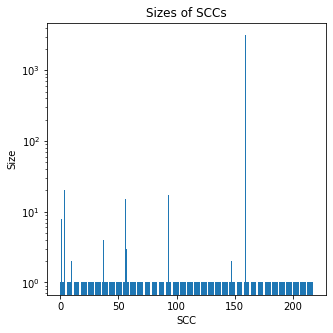

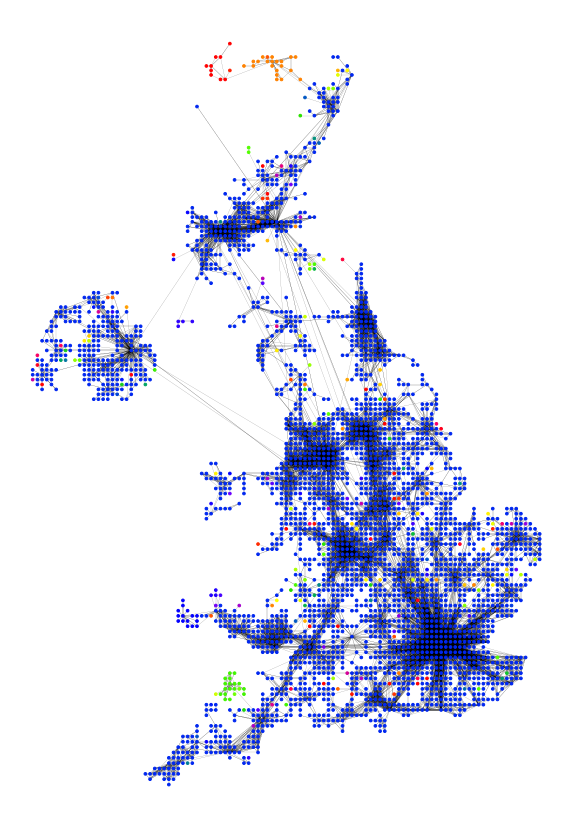

In [19]:
# Compute strongly connected comoonents of LWCC
scc_set = list(nx.strongly_connected_components(lwcc))
n_scc = len(list(scc_set))
print('Number of SCC in LWCC:', n_scc)

# Store component label for each node in LWCC
scc_id = np.zeros(s_lwcc,dtype=int)

# Repeat for each community k
for k in range (0,n_scc):
    # Nodes of the k-th component are marked with k
    nodes = list(scc_set[k])
    for node in nodes:
        scc_id [lwcc_node_dict[node]]=k
        
# Compute sizes of each scc
scc_id_counts = np.histogram(scc_id,bins=np.arange(0,n_scc+1)) [0]
# Plot community sizes as barplot
fig, ax = plt.subplots(1,figsize =(5,5))
ax.bar(np.arange(0,n_scc),scc_id_counts)
ax.set(ylabel = 'Size', xlabel='SCC', title = 'Sizes of SCCs', yscale = 'log')
plt.show()

# Visualise SCCs in LWCC
fig, ax = plt.subplots(1,figsize =(10,15))
nx.draw(lwcc, ax=ax,pos=geom_dict,node_size=7, width = 0.1,  arrows=False,
       node_color = scc_id,cmap = 'prism')
#ax.set(title='SCCs of LWCC')
plt.show()

# LSCC

## Generation of DiGraph for LSCC

In [20]:
# Generate LSCC DiGraph
new_computation = False

if new_computation == False:
    
    # Load data (deserialize)
    with open(root_Base+'/base_network_lscc.npz', 'rb') as handle:
        lscc_dict = pickle.load(handle)
    # Create LSCC DiGraph
    lscc = nx.from_dict_of_dicts(lscc_dict,create_using = nx.DiGraph)

elif new_computation == True:

    # Create subgraph of LSCC and save adjacency matrix
    lscc_nodes = max(nx.strongly_connected_components(G), key=len)
    lscc = G.subgraph(lscc_nodes)
    lscc_dict = nx.to_dict_of_dicts(lscc)
    # Store data (serialize)
    with open(root_base+'/base_network_lscc.npz', 'wb') as handle:
        pickle.dump(lscc_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# Compute adjacency matrix and node list of LSCC
A_LSCC = nx.adjacency_matrix(lscc)
lscc_nodes_list = np.asarray(list(lscc.nodes()))
s_lscc = len(lscc_nodes_list)
print('Nuber of nodes of LSCC:', s_lscc)
print('Number of edges of LSCC:', len(lscc.edges()))

# Compute sparsity of adjacency matrix
sparsity = 100*np.sum(A_LSCC.toarray() == 0.) / A_LSCC.toarray().size
print('Sparsity of LWCC:', np.around(sparsity,2),'%')

# Associate quadkeys with node id's
lscc_node_dict = {list(lscc.nodes)[i] : i for i in range(s_lscc)}

# Subtract self-loops
B_LSCC_array = A_LSCC - np.diag(np.diag(A_LSCC.toarray()))
B_LSCC = sp.csr_matrix(B_LSCC_array)
# Compute vector of out-strengths
ones = np.ones(s_lscc)
d_LSCC = np.asarray(B_LSCC_array.dot(ones)[0]).reshape(-1)
print('Number of sink nodes:', np.sum(d_LSCC==0))

# Compute number of edges in B
print('Number of edges in B:', np.sum(B_LSCC_array > 0))

Nuber of nodes of LSCC: 3125
Number of edges of LSCC: 37349
Sparsity of LWCC: 99.62 %
Number of sink nodes: 0
Number of edges in B: 34224


In [21]:
#in and out degree in LSCC
out_degrees = np.asarray(list(dict(lscc.out_degree()).values()))
print('Mean Degrees Out - LSCC:',np.mean(out_degrees))

in_degrees = np.asarray(list(dict(lscc.in_degree()).values()))
print('Mean Degrees In - LSCC:',np.mean(in_degrees))

Mean Degrees Out - LSCC: 11.95168
Mean Degrees In - LSCC: 11.95168


In [22]:
#number of trips in LSCC
A_dense = A_LSCC.todense()
n_total = A_dense.sum()
n_intra = np.trace(A_dense)
n_inter = n_total-n_intra

print('Total number of trips in LSCC:',n_total)
print('Intra-tile number of trips in LSCC:',n_intra)
print('Inter-tile number of trips in LSCC:',n_inter)



Total number of trips in LSCC: 12892495.342857143
Intra-tile number of trips in LSCC: 10416968.371428572
Inter-tile number of trips in LSCC: 2475526.9714285713


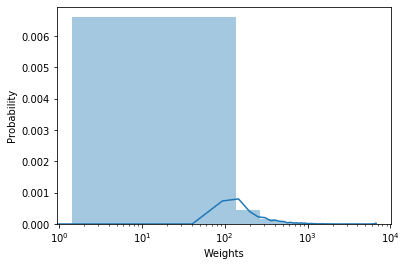

In [23]:
ax = sns.distplot(B_LSCC_array[B_LSCC_array>0])
ax.set(xlabel = 'Weights', ylabel = 'Probability',
       xscale = 'log')
plt.show()

In [24]:
###################################
# Get geometric distances in LSCC #
###################################

# Get polygons from quadkeys
quadkeys = list(lscc.nodes)
n_nodes = len(quadkeys)
polys = []

#Iterates over the quadkeys to extract the tiles
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")

def getXY(pt):
    return (pt.x, pt.y)
centroidseries = gdf['geometry'].centroid
gdf['LONGITUDE'],gdf['LATITUDE'] = [list(t) for t in zip(*map(getXY, centroidseries))]

from math import radians, cos, sin, asin, sqrt

pt_lat = dict(zip(gdf['quadkey'], gdf['LATITUDE']))
pt_long = dict(zip(gdf['quadkey'], gdf['LONGITUDE']))

pt_lat_r = {k: math.radians(v) for k, v in pt_lat.items()}
pt_long_r = {k: math.radians(v) for k, v in pt_long.items()}

pt_tup_1 = []
pt_tup_2 = []
dist_tup = []

# Compute distance in km with Haversine formula
for i in pt_lat_r.keys():
    for j in pt_lat_r.keys():
        pt_tup_1.append(i)
        pt_tup_2.append(j)        
        dist_tup.append(6367 * (2 * asin(sqrt(sin((pt_lat_r.get(i) - pt_lat_r.get(j))/2)**2 + cos((pt_lat_r.get(i))) * cos((pt_lat_r.get(j))) * sin((pt_long_r.get(i) - pt_long_r.get(j))/2)**2))))
        
#Creates Dataframe from tuple
Dist = pd.DataFrame({'start_quadkey': pt_tup_1,'end_quadkey': pt_tup_2,'DISTANCE': dist_tup})

# Compute distance matrix D_geom
D_geom = np.zeros((n_nodes,n_nodes))
for i in range(n_nodes):
    D_geom[i,:] = Dist['DISTANCE'][i*n_nodes:(i+1)*n_nodes]
    
# Store D_geom
root_D_geom = root_Base + '/lscc_D_geom.pickle'
with open(root_D_geom, 'wb') as handle:
    pickle.dump(D_geom, handle, protocol=pickle.HIGHEST_PROTOCOL)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



### Plot of degree distribution in LSCC

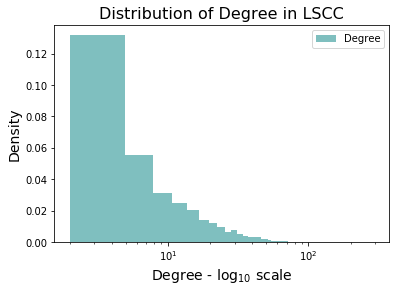

In [83]:
fig,ax = plt.subplots(1)
#ax.hist(np.log(rg_df['2020-03-10']),log = True,alpha =0.4, color = 'orange',nbins = 102)
plt.hist((out_degrees),bins = 100,color = 'teal',label = 'Degree',alpha = 0.5,density = True)
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Distribution of Degree in LSCC',fontsize = 16)
ax.set_xlabel(r'Degree - $\log_{10}$ scale',fontsize = 14)
ax.legend()
ax.set_ylabel('Density',fontsize = 14)
fig.savefig(root_figure + '/Base Network'+'/degree_dist.pdf',bbox_inches='tight')

In [38]:
np.median(out_degrees)


6.0

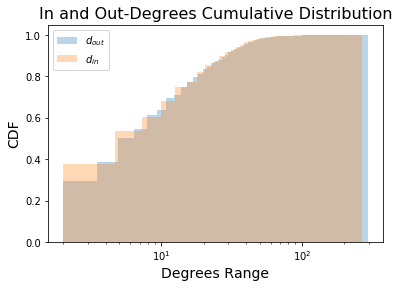

In [82]:
fig,ax = plt.subplots(1)
n, bins, patches = ax.hist(out_degrees, 199, density=True, alpha = 0.3,
                           cumulative=True, label=r'$d_{out}$')
n, bins, patches = ax.hist(in_degrees, 100, density=True, alpha = 0.3,
                           cumulative=True, label=r'$d_{in}$')
ax.set_xscale('log')
ax.legend()
ax.set_title('In and Out-Degrees Cumulative Distribution',fontsize = 16)
ax.set_ylabel('CDF',fontsize = 14)
ax.set_xlabel('Degrees Range',fontsize = 14)
fig.savefig(root_figure + '/Base Network'+'/in_out_degrees.pdf',bbox_inches='tight')



In [ ]:
np.median(out_degrees)

In [39]:
np.median(in_degrees)

7.0

## Visualisation of LSCC

In [19]:
def visualse_largest_components(G):
    '''
    input: directed network G
    output: array that indicates nodes that are in LSCC and LWCC
    '''
    
    # Compute weakly connected components of G
    n_nodes = len(list(G.nodes()))
    wcc_set = list(nx.weakly_connected_components(G))
    n_wcc = len(list(wcc_set))

    # Store component label for each node in G
    wcc_id = np.zeros(n_nodes,dtype=int)

    # Repeat for each community k
    for k in range (0,n_wcc):
        # Nodes of the k-th component are marked with k
        nodes = list(wcc_set[k])
        for node in nodes:
            wcc_id [node_dict[node]]=k

    # Compute sizes of each component
    unordered_counts = np.histogram(wcc_id,bins=np.arange(0,n_wcc+1)) [0]
    # Get component indices sorted according to size
    component_ranked = np.argsort(-unordered_counts)
    # Create dictionary that describes map from old labels to new labels
    rank = {component_ranked[k] : k for k in range(0,n_wcc)}
    # Apply permutation to labels
    wcc_id_ranked = wcc_id.copy()
    for i in range (0,len(wcc_id_ranked)):
        wcc_id_ranked[i] = rank[wcc_id_ranked[i]]
    
    # Get indicator for LWCC
    ind_lwcc = np.asarray(wcc_id_ranked == 0, dtype = 'int')
    
    # Compute strongly connected comoonents of G
    scc_set = list(nx.strongly_connected_components(G))
    n_scc = len(list(scc_set))

    # Store component label for each node in G
    scc_id = np.zeros(n_nodes,dtype=int)

    # Repeat for each community k
    for k in range (0,n_scc):
        # Nodes of the k-th component are marked with k
        nodes = list(scc_set[k])
        for node in nodes:
            scc_id [node_dict[node]]=k

    # Compute sizes of each component
    unordered_counts = np.histogram(scc_id,bins=np.arange(0,n_scc+1)) [0]
    # Get component indices sorted according to size
    component_ranked = np.argsort(-unordered_counts)
    # Create dictionary that describes map from old labels to new labels
    rank = {component_ranked[k] : k for k in range(0,n_scc)}
    # Apply permutation to labels
    scc_id_ranked = scc_id.copy()
    for i in range (0,len(scc_id_ranked)):
        scc_id_ranked[i] = rank[scc_id_ranked[i]]
        
    ind_lscc = np.asarray(scc_id_ranked == 0, dtype = 'int')
    
    return ind_lwcc + ind_lscc
    
    

In [20]:
# Compute weakly connected components of G
n_nodes = len(list(G.nodes()))
wcc_set = list(nx.weakly_connected_components(G))
n_wcc = len(list(wcc_set))
print('Number of WCC in G:', n_wcc)

# Store component label for each node in G
wcc_id = np.zeros(n_nodes,dtype=int)

# Repeat for each community k
for k in range (0,n_wcc):
    # Nodes of the k-th component are marked with k
    nodes = list(wcc_set[k])
    for node in nodes:
        wcc_id [node_dict[node]]=k

# Compute sizes of each component
unordered_counts = np.histogram(wcc_id,bins=np.arange(0,n_wcc+1)) [0]
# Get component indices sorted according to size
component_ranked = np.argsort(-unordered_counts)
# Create dictionary that describes map from old labels to new labels
rank = {component_ranked[k] : k for k in range(0,n_wcc)}
# Apply permutation to labels
wcc_id_ranked = wcc_id.copy()
for i in range (0,len(wcc_id_ranked)):
    wcc_id_ranked[i] = rank[wcc_id_ranked[i]]

Number of WCC in G: 1956


In [21]:
print('Number of singleton WCCs:', 100*np.sum(unordered_counts == 1)/n_wcc)

Number of singleton WCCs: 98.77300613496932


In [22]:
ind_lwcc = np.asarray(wcc_id_ranked == 0, dtype = 'int')

In [23]:
# Compute strongly connected comoonents of G
scc_set = list(nx.strongly_connected_components(G))
n_scc = len(list(scc_set))
print('Number of SCC in G:', n_scc)

# Store component label for each node in G
scc_id = np.zeros(n_nodes,dtype=int)

# Repeat for each community k
for k in range (0,n_scc):
    # Nodes of the k-th component are marked with k
    nodes = list(scc_set[k])
    for node in nodes:
        scc_id [node_dict[node]]=k
        
# Compute sizes of each component
unordered_counts = np.histogram(scc_id,bins=np.arange(0,n_scc+1)) [0]
# Get component indices sorted according to size
component_ranked = np.argsort(-unordered_counts)
# Create dictionary that describes map from old labels to new labels
rank = {component_ranked[k] : k for k in range(0,n_scc)}
# Apply permutation to labels
scc_id_ranked = scc_id.copy()
for i in range (0,len(scc_id_ranked)):
    scc_id_ranked[i] = rank[scc_id_ranked[i]]

Number of SCC in G: 2193


In [24]:
ind_lscc = np.asarray(scc_id_ranked == 0, dtype = 'int')

In [25]:
from matplotlib.colors import ListedColormap
newcmp = ListedColormap(['grey','b','forestgreen'])

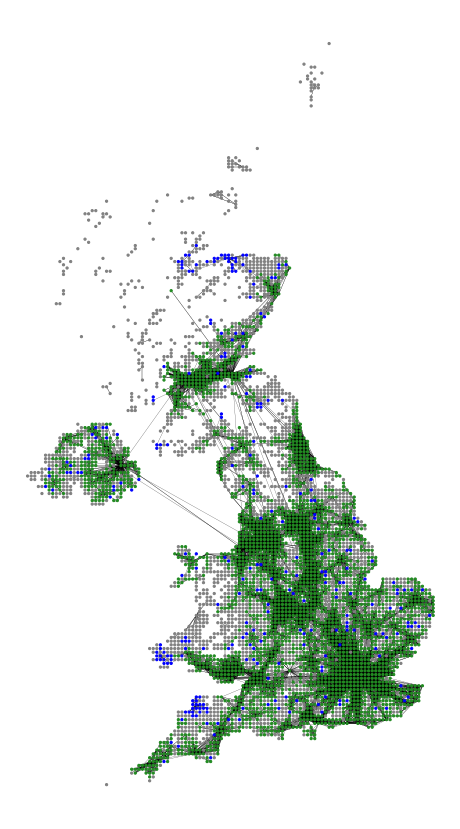

In [26]:
# Visualise LSCC in G
fig, ax = plt.subplots(1,figsize =(8,15))
nx.draw(G, ax=ax,pos=geom_dict,node_size=5, width = 0.2,  arrows=False,
       node_color = visualse_largest_components(G),cmap =newcmp)
plt.show()
fig.savefig(root_figure+'Base Network/'+'lscc_in_base.eps', dpi=10,bbox_inches='tight')

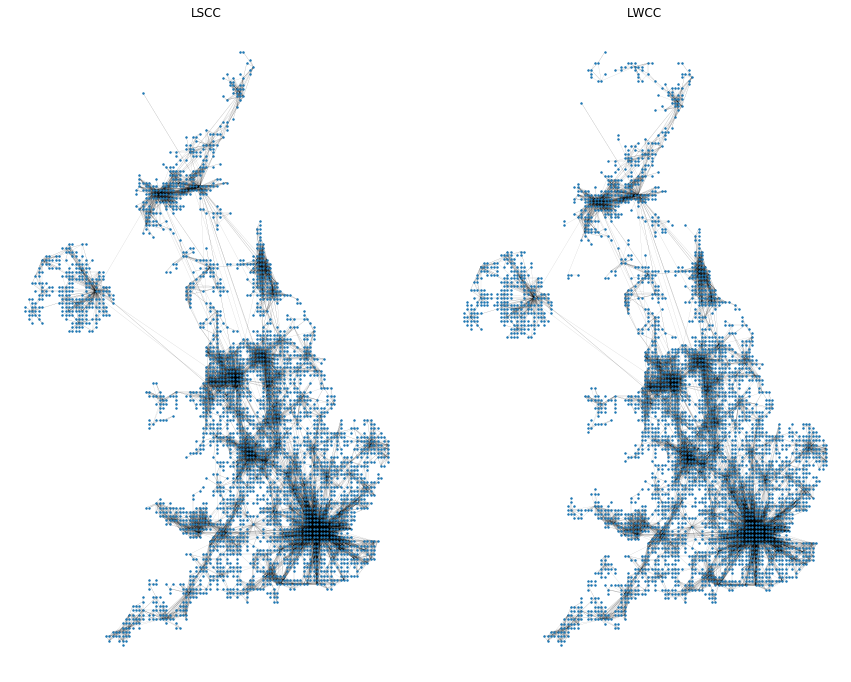

In [27]:
# Create subplot and draw graph
fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(wspace=0.1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

nx.draw(lscc, ax=ax1,pos=geom_dict,node_size=2, width = 0.05,  arrows=False)
nx.draw(lwcc, ax=ax2,pos=geom_dict,node_size=2, width = 0.05,  arrows=False)

ax1.set(title='LSCC')
ax2.set(title='LWCC')

plt.show()

In [28]:
# Create GeoDataFrame for LSCC nodes
quadkeys = list(lscc.nodes())
polys = []

# Iterate over all quadkeys to create corresponding polygons
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]
gdf_lscc = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")
gdf_lscc = gdf_lscc.to_crs("EPSG:3395")

# Import NUTS shape files
root = '/Users/ignaciosacristanbarba/Documents/M4R/Data'
root_map = root+'/NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'
map_gdf = gpd.read_file(root_map)
map_gdf = map_gdf.to_crs("EPSG:3395")

# Get NUTS3 
cols = [0,2,3,4,5,6,7,8]
gdf_NUTS3 = map_gdf.drop(map_gdf.columns[cols],axis=1)
gdf_NUTS3.rename(columns={'nuts318cd': 'nuts'}, inplace=True)

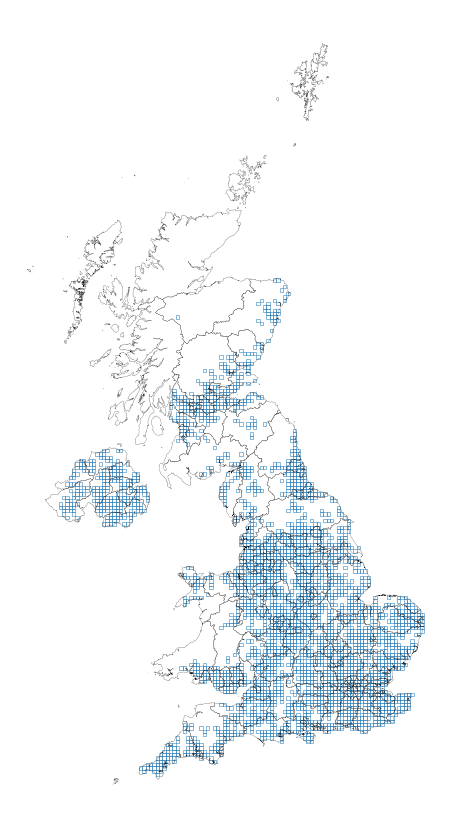

In [29]:
# plot 
fig, ax = plt.subplots(1,figsize =(10,15))
gdf_NUTS3.boundary.plot(linewidth=0.2, ax=ax, color = 'black')
gdf_lscc.plot(ax=ax, linewidth = 0.5, edgecolor='tab:blue', facecolor = 'none',)
ax.set_axis_off()
fig.savefig(root_figure+'Base Network/'+'lscc_NUTS3.eps', dpi=fig.dpi,bbox_inches='tight')